<a href="https://colab.research.google.com/github/liuxx479/HMF/blob/master/As_si8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
########## install astropy, camb, and hmf
!pip install astropy
!pip install camb

     |████████████████████████████████| 1.6MB 10.6MB/s 
  Created wheel for camb: filename=camb-1.3.2-cp37-none-any.whl size=973503 sha256=b31289a084d332b892ea8b89a0c086ae730b233c69499b8f0adb8fc51e90f873
  Stored in directory: /root/.cache/pip/wheels/35/a2/8f/5d3c22c8dc8ab613af9be628f6408f4c2817b7ed85d3feb469
Successfully built camb


In [ ]:
# ######### mount google drive file
# from google.colab import drive
# drive.mount('/content/drive')
# root = '/content/drive/My Drive/HMF/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
from pylab import *
import os
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from scipy import optimize
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
%matplotlib inline

Using CAMB 1.3.2 installed at /usr/local/lib/python3.7/dist-packages/camb


In [4]:
####### check TT, Pk (z=0), Clkk (z=1) from class vs camb

# LCDM parameters
A_s = 2.1e-9
h=0.7
OmegaB = 0.046
OmegaM = 0.3
n_s = 0.97
tau = 0.054 ## only for primary CMB, not used for now, for simplicity

# beyond LCDM, not implemented yet
OmegaDE = 0.75
w0=-1.0#-0.5#
wa=0.0#0.1#
Neff = 3.046
mnu = 0.0

### derived parameters
#z_reio = 10.0 #11.357
ombh2 = OmegaB*h**2
omch2 = (OmegaM-OmegaB)*h**2
H0=h*100
### accuracy parameters
lmax=5000

In [13]:
#### delta m21^2=7.37e-5
#### |delta m^2| = 2.5e-3 (normal) 2.46e-3 (inverted)
d31N = 2.5e-3
d31I = 2.46e-3
d21 = 7.37e-5

m2fcn = lambda m1: sqrt(d21 + m1**2)
m3_NH = lambda m1: sqrt(d31N + 0.5*m2fcn(m1)**2 +0.5*m1**2)
m3_IH = lambda m1: sqrt(0.5*m2fcn(m1)**2 +0.5*m1**2 - d31I)
root_NH = lambda m1, M: M-(m1+m2fcn(m1)+m3_NH(m1))
root_IH = lambda m1, M: M-(m1+m2fcn(m1)+m3_IH(m1))

Mmin_NH = sqrt(d21)+sqrt(d31N+d21/2)
Mmin_IH = sqrt(d31I-0.5*d21) + sqrt(d31I+0.5*d21)
m1min_IH = sqrt(d31I-0.5*d21)

def neutrino_mass_calc (M, split=1):
    '''split = 1, 2, 3 for normal, inverted, degenerate
    '''    
    #print M
    if M==0:
        m1,m2,m3=zeros(3)
    else:
        if split == 1:
            m1=optimize.bisect(root_NH, 0, M, args=(M,))       
            m2=m2fcn(m1)
            m3=m3_NH(m1)
        elif split == 2:
            m1=optimize.bisect(root_IH, m1min_IH, M, args=(M,))
            m2=m2fcn(m1)
            m3=m3_IH(m1)
        elif split ==3:
            m1, m2, m3 = ones(3)*M/3.0
    return m1,m2,m3
    
def Mnu2Omeganu(M_nu, omega_m):
    mnu_arr = array(neutrino_mass_calc(M_nu)) * u.eV
    cosmo = FlatLambdaCDM(H0=H0, Om0=OmegaM, m_nu=mnu_arr)
    return cosmo.Onu0

zarr=[0,]#[2,1,0]
def find_si8(mnu, A_s, OmegaM=OmegaM, h=h, n_s=n_s, ombh2=ombh2):
  # print (mnu, A_s)
  pars = camb.CAMBparams()

  if mnu==0:
      omnuh2=0
  else:
      omnuh2 = Mnu2Omeganu(mnu, OmegaM)*h**2
  omch2 = OmegaM*h**2 - omnuh2 - ombh2

  pars.set_cosmology(H0=h*100.0, ombh2=ombh2, omch2=omch2, omk=0, 
                    tau=0, mnu=mnu, neutrino_hierarchy='normal')
  pars.InitPower.set_params(As=A_s, ns=n_s, r=0)
  pars.set_matter_power(redshifts=zarr, kmax=0.1)
  results = camb.get_results(pars)
  si8=results.get_sigma8()
  return si8

In [6]:
Nbin=2
mnu_arr = linspace(0,0.5,Nbin)
As_arr = linspace(1.8e-9, 2.4e-9, Nbin+1)
out = zeros(shape=(Nbin,Nbin+1,len(zarr)))
out_om = zeros(shape=(Nbin,Nbin+1,len(zarr)))

i=0
for mnu in mnu_arr:
  j=0
  for As in As_arr:
    out[i,j]=find_si8(mnu, As)
    out_om[i,j]=find_si8(mnu, As, OmegaM=0.25)
    j+=1
  i+=1

0.0 1.8e-09
0.0 1.8e-09
0.0 2.0999999999999998e-09
0.0 2.0999999999999998e-09
0.0 2.4e-09
0.0 2.4e-09
0.5 1.8e-09
0.5 1.8e-09
0.5 2.0999999999999998e-09
0.5 2.0999999999999998e-09
0.5 2.4e-09
0.5 2.4e-09


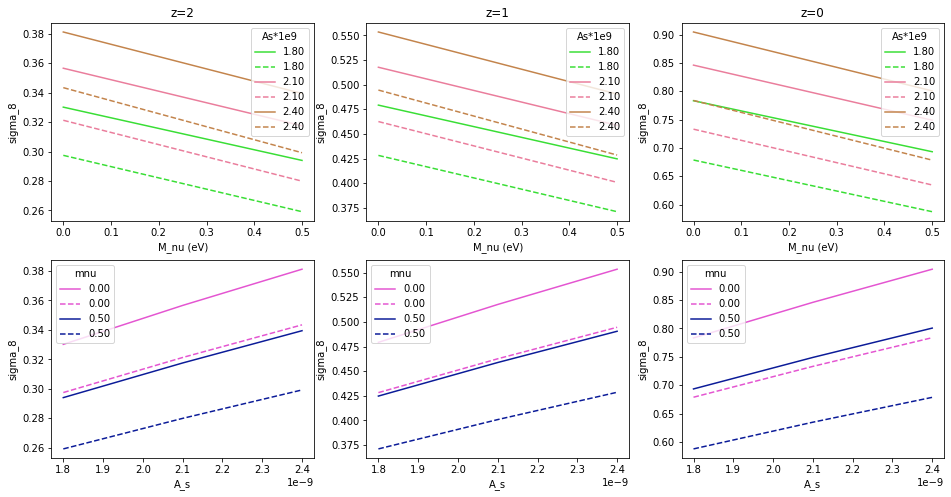

In [9]:
# save(root+'test_out',out)
figure(figsize=(16,8))
for j in range(len(zarr)):
  seed(5)
  subplot(2,3,1+j)
  for i in range(Nbin+1):
    icolor=rand(3)
    plot(mnu_arr, out[:,i,j], color=icolor, label='%.2f'%(As_arr[i]*1e9))
    plot(mnu_arr, out_om[:,i,j], '--',color=icolor, label='%.2f'%(As_arr[i]*1e9))
  xlabel('M_nu (eV)')
  ylabel('sigma_8')
  legend(title='As*1e9',ncol=1)
  title('z=%s'%(zarr[j]))

  seed(6)
  subplot(2,3,4+j)
  for i in range(Nbin):
    icolor=rand(3)
    plot(As_arr, out[i,:,j],color=icolor, label='%.2f'%(mnu_arr[i]))
    plot(As_arr, out_om[i,:,j], '--',color=icolor, label='%.2f'%(mnu_arr[i]))
  xlabel('A_s')
  ylabel('sigma_8')
  legend(title='mnu',ncol=1)
show()

In [ ]:
results.get_sigma8

array([[0.78326457, 0.81524761, 0.84602242, 0.87571641, 0.90443601],
       [0.76211282, 0.79323218, 0.82317593, 0.85206804, 0.88001209],
       [0.7383259 , 0.76847396, 0.79748311, 0.82547345, 0.85254531],
       [0.71519   , 0.74439335, 0.77249349, 0.79960673, 0.82583028],
       [0.69333249, 0.72164333, 0.74888468, 0.77516928, 0.80059139]])

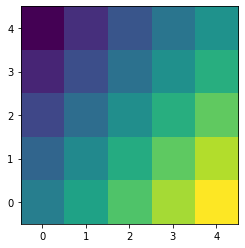

In [ ]:
imshow(out,interpolation='nearest', origin='lower')

In [14]:
# find_si8(mnu, A_s, OmegaM=OmegaM, h=h, n_s=n_s, ombh2=ombh2):

print (find_si8(mnu=0, A_s=2.1e-9, OmegaM=0.3, h=0.7, n_s=0.97, ombh2=0.0225))
print (find_si8(mnu=0.1, A_s=2.1e-9, OmegaM=0.3, h=0.7, n_s=0.97, ombh2=0.0225))
print (find_si8(mnu=0, A_s=2.2e-9, OmegaM=0.3, h=0.7, n_s=0.97, ombh2=0.0225))
print (find_si8(mnu=0, A_s=2.1e-9, OmegaM=0.35, h=0.7, n_s=0.97, ombh2=0.0225))
print (find_si8(mnu=0, A_s=2.1e-9, OmegaM=0.3, h=0.75, n_s=0.97, ombh2=0.0225))
print (find_si8(mnu=0, A_s=2.1e-9, OmegaM=0.3, h=0.7, n_s=0.99, ombh2=0.0225))
print (find_si8(mnu=0, A_s=2.1e-9, OmegaM=0.3, h=0.7, n_s=0.97, ombh2=0.025))



[0.84646154]
[0.82858613]
[0.86638101]
[0.94327425]
[0.94965272]
[0.85312087]
[0.81931567]


In [11]:
ombh2

0.022539999999999998